# Подготовка модели для предсказания погоды


Необходимые импорты и игнорирование предупреждений  


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.calibration import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

import warnings
warnings.filterwarnings("ignore")

# Обзор данных 

* Ознакомление с данными и их структурой.

* Проверка наличия пропущенных значений, выбросов и ошибок в данных.

In [24]:
data = pd.read_csv('weather_data.csv')
data.head(3)

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"


In [25]:
data = data.rename(columns={'Dew Point Temp_C': 'Dew Point (C)', 'Temp_C': 'Temperature (C)', 'Rel Hum_%': 'Humidity',
                            'Wind Speed_km/h': 'Wind Speed (km/h)','Visibility_km': 'Visibility (km)',
                            'Press_kPa': 'Pressure (kPa)'})
print(f'Типы данных столбцов:\n {data.dtypes}\n')
print(f'Количество пропущенных значений:\n {data.isnull().sum()}')

Типы данных столбцов:
 Date/Time             object
Temperature (C)      float64
Dew Point (C)        float64
Humidity               int64
Wind Speed (km/h)      int64
Visibility (km)      float64
Pressure (kPa)       float64
Weather               object
dtype: object

Количество пропущенных значений:
 Date/Time            0
Temperature (C)      0
Dew Point (C)        0
Humidity             0
Wind Speed (km/h)    0
Visibility (km)      0
Pressure (kPa)       0
Weather              0
dtype: int64


Преобразование столбца `Date/Time` в формат `datetime` для
построения графиков временных рядов

In [26]:
data["Date/Time"] = pd.to_datetime(data["Date/Time"], format="%m/%d/%Y %H:%M")
data.head(3)

,Date/Time,Temperature (C),Dew Point (C),Humidity,Wind Speed (km/h),Visibility (km),Pressure (kPa),Weather
0,2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"


# Статистический анализ 

* Вычисления основных статистических характеристик для каждого признака (среднее, медиана, минимум, максимум и т.д.).

In [27]:
numeric_columns = data.select_dtypes(include='number')
numeric_columns.describe()

,Temperature (C),Dew Point (C),Humidity,Wind Speed (km/h),Visibility (km),Pressure (kPa)
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,8.798144,2.555294,67.431694,14.945469,27.664447,101.051623
std,11.687883,10.883072,16.918881,8.688696,12.622688,0.844005
min,-23.300000,-28.500000,18.000000,0.000000,0.200000,97.520000
25%,0.100000,-5.900000,56.000000,9.000000,24.100000,100.560000
50%,9.300000,3.300000,68.000000,13.000000,25.000000,101.070000
75%,18.800000,11.800000,81.000000,20.000000,25.000000,101.590000
max,33.000000,24.400000,100.000000,83.000000,48.300000,103.650000


# Визуализация данных(EDA)

* Построение гистограмм распределений для каждого признака.

* Изучение зависимостей между признаками, используя диаграммы рассеяния и корреляционную матрицы.

* Изучение изменение погоды во времени с помощью графиков временных рядов.

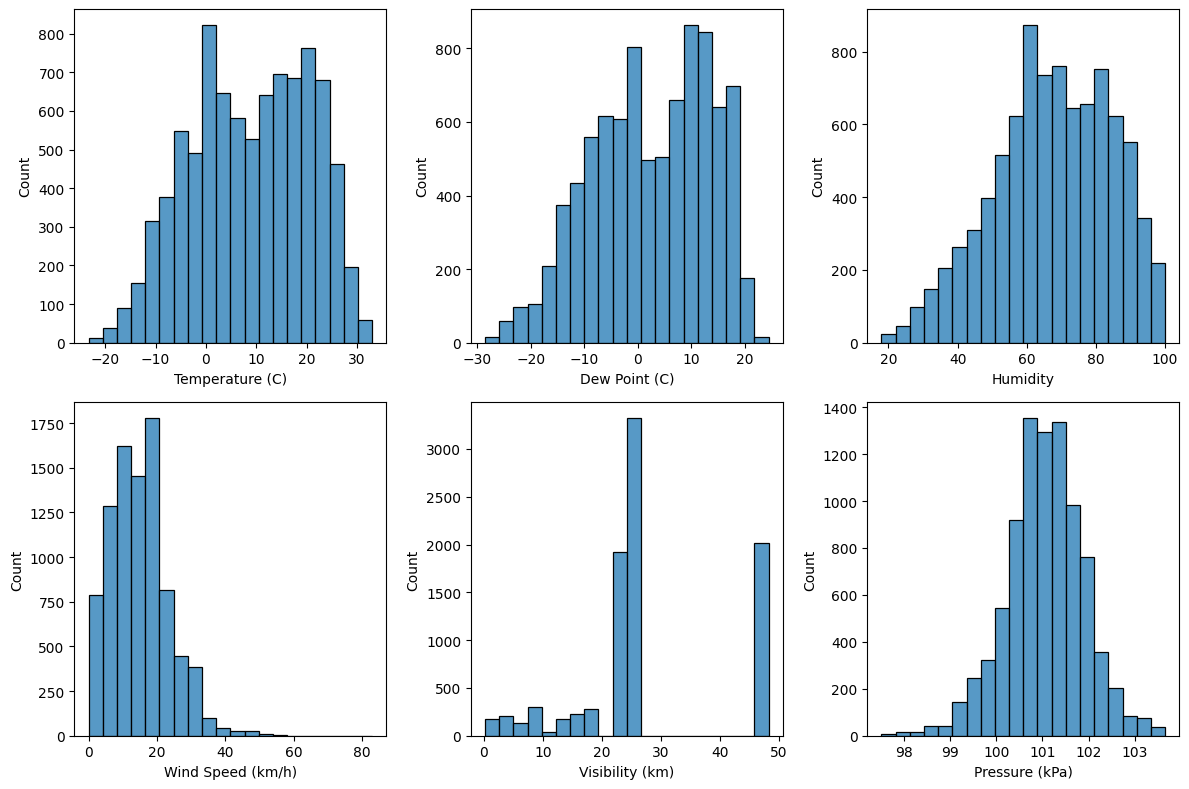

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

sns.histplot(data['Temperature (C)'], bins=20, ax=axs[0, 0])
sns.histplot(data['Dew Point (C)'], bins=20, ax=axs[0, 1])
sns.histplot(data['Humidity'], bins=20, ax=axs[0, 2])
sns.histplot(data['Wind Speed (km/h)'], bins=20, ax=axs[1, 0])
sns.histplot(data['Visibility (km)'], bins=20, ax=axs[1, 1])
sns.histplot(data['Pressure (kPa)'], bins=20, ax=axs[1, 2])

plt.tight_layout()
plt.show()


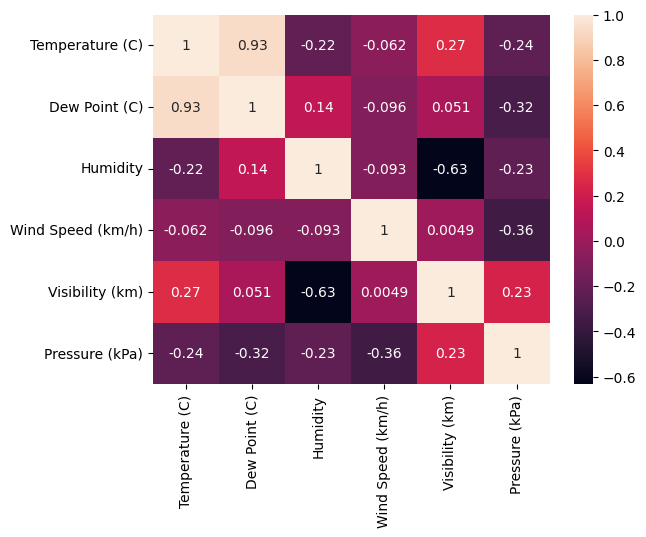

In [29]:
numeric_columns = data.select_dtypes(include='number')
corr_matrix = numeric_columns.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

На гистограмме `Visibility (km)` форма распределения случайная, в данных нет четкой закономерности и они могут искажать результаты, но так как `Visibility (km)` не плохо корреллирует с `Temperature (C)` и с другими признаками он может улучшить качество модели.

# Графики временных рядов

Графики временных рядов могут помочь в понимании того, как выбранные признаки изменяются со временем и как они взаимосвязаны с целевой переменной.

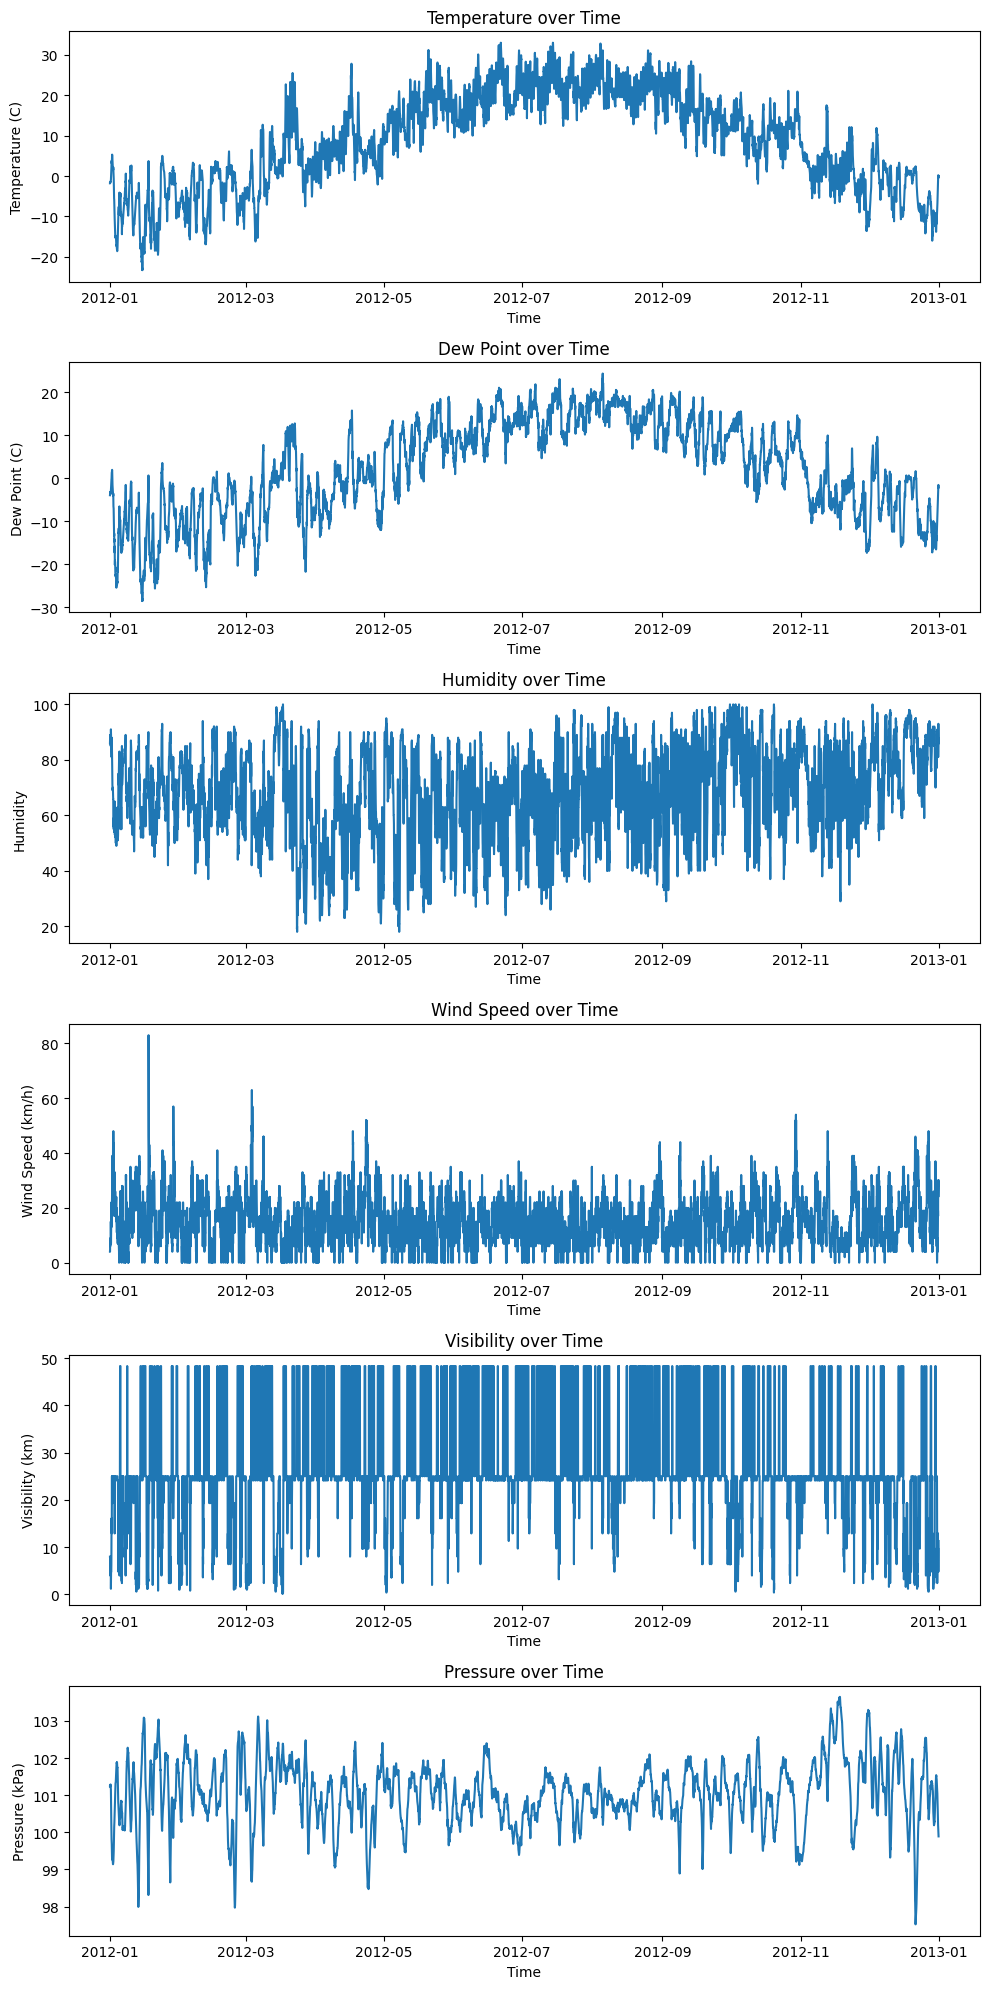

In [30]:
data.set_index('Date/Time', inplace=True)

fig, axs = plt.subplots(6, 1, figsize=(10, 20))

axs[0].plot(data['Temperature (C)'])
axs[0].set_title('Temperature over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature (C)')

axs[1].plot(data['Dew Point (C)'])
axs[1].set_title('Dew Point over Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Dew Point (C)')

axs[2].plot(data['Humidity'])
axs[2].set_title('Humidity over Time')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Humidity')

axs[3].plot(data['Wind Speed (km/h)'])
axs[3].set_title('Wind Speed over Time')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Wind Speed (km/h)')

axs[4].plot(data['Visibility (km)'])
axs[4].set_title('Visibility over Time')
axs[4].set_xlabel('Time')
axs[4].set_ylabel('Visibility (km)')

axs[5].plot(data['Pressure (kPa)'])
axs[5].set_title('Pressure over Time')
axs[5].set_xlabel('Time')
axs[5].set_ylabel('Pressure (kPa)')

plt.tight_layout()
plt.show()

На графиках временных рядов видно, что `Temperature (C)`, `Dew Point (C)`, `Humidity` и `Pressure (kPa)` имеют сезонную и циклическую закономерность в данных. Они взаимосвязаны с целевой переменной и могут быть использованы для улучшения качества модели.